# Bank telemarketing
This notebook presents an analysis of a telemarketing campaign of a Portuguese banking institution that took place between May 2008 and November 2010.  During the campaign, clients were contacted by phone and asked if they were interested in a bank term deposit.
Here, I will develop a machine learning model that could help make future telemarketing campaigns more efficient. The model is based on personal information about the clients, the setup of the current and previous marketing campaigns, and some parameters describing the state of the economy at the time when the clients were contacted. In total, there are 20 features, both, numerical and categorical ones. The data set contains 41188 instances.

More information about the data set are available [here](https://www.kaggle.com/impapan/bank-marketing-dataset).

Source: \
S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

(Note: Not all the features analyzed by Moro et al. are included in this data set for privacy reasons.)

In [1]:
# Import the relevant modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix

## Auxiliary functions
Below are some functions that are used later in the notebook.

In [2]:
def load_data(filename):
    '''Loads the data, divides them in features and label.'''
    data = pd.read_csv(filename,sep=';')
    
    X = data.drop('y',axis=1)
    y = data.y == 'yes'
    
    return X,y



def feature_engineering_num(X_train,X_test):
    '''Takes the train and the test data, performs preprocessing and feature engineering for the numerical features.'''

    # The relevant numerical features are "emp.var.rate" (employment variation rate), "cons.price.idx" (consumer price index)",
    # "cons.conf.idx" (consumer confidence index), "euribor3m" (euribor 3 month rate), and "nr.employed" (number of employees),
    # which describe the state of the economy. In addition, the feature "campaign" (how many times was a client contacted during
    # the current telemarketing campaign) is used. These features do not exhibit any missing data.
    # Including additional numerical features from the data set does not improve the quality of the model.
        
    
    # PCA for the economical features
    # There are several features describing the state of the economy. These are highly correlated.
    # Three principal components capture more than 99 % of the variance
    economic = ['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
    sc = StandardScaler()
    pca = PCA(n_components=3)

    dummy = X_train[economic]
    dummy = sc.fit_transform(dummy)
    econ_train = pca.fit_transform(dummy)
    econ_train = pd.DataFrame(econ_train,columns=['economic_pca_1','economic_pca_2','economic_pca_3'],index=X_train.index)

    dummy = X_test[economic]
    dummy = sc.transform(dummy)
    econ_test = pca.transform(dummy)
    econ_test = pd.DataFrame(econ_test,columns=['economic_pca_1','economic_pca_2','economic_pca_3'],index=X_test.index)
    
    
    #Combine the result of the PCA with the "campaign" feature in a dataframe.
    X_train_num = pd.concat([X_train[['campaign']],econ_train],axis=1)
    X_test_num = pd.concat([X_test[['campaign']],econ_test],axis=1)

    
    # Scaling of the data. The "campaign" feature exhibits a strongly right skewed distribution.
    # Therefore, a min-max scaler is used. The results from the PCA are transformed using a standard scaler.
    selective = ColumnTransformer([('minmax', MinMaxScaler(), ['campaign'])], remainder=StandardScaler())
    X_train_num_sc = pd.DataFrame(selective.fit_transform(X_train_num),index=X_train_num.index,columns=X_train_num.columns)
    X_test_num_sc = pd.DataFrame(selective.transform(X_test_num),index=X_test_num.index,columns=X_test_num.columns)


    return X_train_num_sc, X_test_num_sc



def feature_engineering_cat(data):
    '''Takes the train or the test data, performs preprocessing and feature engineering for the categorical data.'''
    
    # The relevant categorical features are "marital" (which describes the marital status of the client), "education", and
    # "poutcome" (whether or not a client subscribed to a term deposit in a previous telemarketing campaign).
    # The features "marital" and "education" exhibits a small fraction of missing data (0.2 % of the "marital feature",
    # 4 % of the feature "education"), labeled as "unknown".
    
    
    # The "marital" feature exhibits four categories from which some have a similar influence on the target variable.
    # Therefore, I generate a new feature describing the marital status that contains only two categories.
    # In addition, I apply a one-hot encoder to the feature.
    marital_map = {'divorced': 'mar_1','married': 'mar_1','single': 'mar_2','unknown': 'mar_2'}
    mar_map = pd.get_dummies(data['marital'].map(marital_map))

    # The "education" feature exibits eight categories. I generate a new feature describing the education that contains only two
    # categories. In addition, I apply a One-hot encoder to the feature.
    edu_map = {'basic.9y': 'edu_1','basic.6y': 'edu_1','basic.4y': 'edu_2','high.school': 'edu_2', 'professional.course': 'edu_2','university.degree': 'edu_3','unknown': 'edu_3','illiterate': 'edu_3'}
    edu_map = pd.get_dummies(data['education'].map(edu_map))
    
    # The "poutcome feature" contains three categories. I apply a One-hot encoder to the feature.
    poutcome = pd.get_dummies(data.poutcome,prefix='poutcome')
    
    
    # Combine the relevant categorical features in a dataframe
    data_cat = pd.concat([mar_map,edu_map,poutcome],axis=1)  
    data_cat['no_default'] = data['default'] == 'no'    # the client does not have a credit in default
    data_cat['contact_cellular'] = data['contact'] == 'cellular'  # contacting the client on their mobil phone seems to be more efficient
    data_cat['age60'] = data['age'] > 60   # people older than 60 are more likely to subscribe to a term deposit
    
    return data_cat



def optimize_gradboost(X_train,y_train):
    '''Takes the training data, optimizes a Gradient Boosting classifier.'''
    
    gbc =  GradientBoostingClassifier(random_state=42)
    
    params = {
        'min_samples_split':np.arange(0.001,0.02,0.002),
        'min_samples_leaf':np.arange(10,500,50),
        'max_depth':np.arange(2,10,2),
        'max_features':['auto', 'sqrt', 'log2'],
        'n_estimators':[150,200,250,300],
        'learning_rate':[0.08,0.09,0.1,0.11,0.12],
        'subsample':np.arange(0.2,1.2,0.2)
    }

    # The parameter space is very large. Therefore, I use RandomizedSearchCV.
    #clf_gbc = GridSearchCV(gbc,params,scoring='roc_auc',n_jobs=-1,cv=3)
    clf_gbc = RandomizedSearchCV(gbc,params,scoring='roc_auc',n_jobs=-1,cv=3,random_state=42,n_iter=50)

    clf_gbc.fit(X_train,y_train)
    
    return clf_gbc



def plot_learning_curve(estimator,X,y,train_sizes,cv):
    '''Takes an estimator, the features and labels, computes and plots a learning curve'''
    
    train_sizes, train_scores, valid_scores = learning_curve(estimator,X,y,train_sizes=train_sizes,cv=cv,scoring='roc_auc',n_jobs=-1,shuffle=True,random_state=42)

    fig, ax = plt.subplots()
    plt.plot(train_sizes, np.mean(train_scores,1), label = 'Training score')
    plt.plot(train_sizes, np.mean(valid_scores,1), label = 'Validation score')
    ax.set_xlabel('Training set size', fontsize = 14)
    ax.set_ylabel('ROC AUC', fontsize = 14)
    ax.legend()
    ax.set_title('Learning curve')
    
    
    
def plot_confusion_matrix(y_true,y_proba,thr):
    '''Takes the true labels, the predicted probabilities, and a threshold for the probability. Computes and plots a confusion matrix. '''

    cm = confusion_matrix(y_true,y_proba > thr)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax, cbar_kws={'label': 'counts'})
    ax.set_title('Confusion matrix')

## Prepare the data and optimize a Gradient Boosting classifier
I use the functions defined above to preprocess the data and to optimize a Gradient Boosting classifier in order to predict whether  a client is interested in a term deposit. Only 11 % of the clients, that were contacted, subscribed to a term deposit, making the label highly imbalanced. I chose a model that predicts the probability for a client to subscribe to a term deposit, since this allows to tune the threshold of the probability. Therefore, I use Area Under the Receiver Operating Characteristic Curve (ROC AUC) score as a metric.
After tuning the hyperparameters, the Gradient Boosting classifier achieves an ROC AUC score of 0.8. I also tested the performance of other kinds of models (e.g., a Support Vector Machine or a Random Forest), but these performed worse than the Gradient Boosting classifier.

In [3]:
# Load the data
X,y = load_data('bank-additional-full.csv')

# Divide in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Preprocessing of the categorical features
X_train_cat = feature_engineering_cat(X_train)
X_test_cat = feature_engineering_cat(X_test)

# Preprocessing of the numerical features
X_train_num, X_test_num = feature_engineering_num(X_train,X_test)

# Combine numerical and categorical features
X_train_comb = pd.concat([X_train_num,X_train_cat],axis=1)
X_test_comb = pd.concat([X_test_num,X_test_cat],axis=1)


# Optimize Gradient Boosting (maximize roc_auc score)
gradboost = optimize_gradboost(X_train_comb,y_train)


# Model performance
display('Gradient Boosting: ROC AUC =  {:.2f}'.format(gradboost.best_score_))

# Model parameters for the best solution:
display('Best parameters: ')
for key,value in gradboost.best_params_.items():
    print(key, ':', value)

'Gradient Boosting: ROC AUC =  0.80'

'Best parameters: '

subsample : 1.0
n_estimators : 250
min_samples_split : 0.005
min_samples_leaf : 160
max_features : auto
max_depth : 6
learning_rate : 0.11


## Learning curve
After testing several types of models, I achieved the best performance with a Gradient Boosting classifier (ROC AUC = 0.8). In the following, I evaluate the performance of the model in more detail by computing a learning curve and a confusion matrix.
The learning curve (see below) shows that the performance of the Gradient Boosting is predominantly limited by the bias. Adding more features to the data set could help improve the quality of the model. In addition, the training score and the validation have not converged yet. Hence, the quality of the model can be improved by adding more instances. However, the gap between the two curves is small compared to the bias.

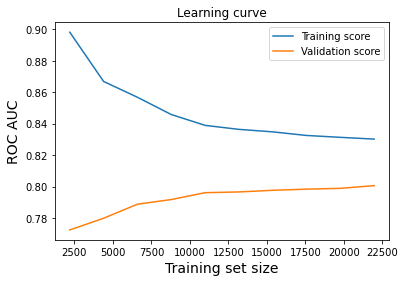

In [4]:
# Learning curve
gbc =  GradientBoostingClassifier(**gradboost.best_params_)

train_sizes=np.arange(0.1,1.1,0.1)
plot_learning_curve(gbc,X_train_comb,y_train,train_sizes,3)


## Threshold for the probability
The Gradient Boosting classifier provides an estimate of the probability for a client subscribing to a term deposit. Here, I determine the optimal threshold for the probability that should be used for the classification, i.e., minimizing the number of false negatives and false positive. For this purpose, I derive the probability predicted by the model for a set of validation data. Then, I plot a histogram of the resulting probabilities while distinguishing between positive (y = 1) and negative (y = 0) labels (see below).
The histograms show that for most instances with negative labels (y = 0), the predicted probability is below about 0.2. Unfortunately, however, a significant fraction of the instances with positive labels (y = 1) get assigned a probability below 0.2, as well. Nonetheless, I will use a probability of 0.2 in the following for distinguishing between positive and negative outcomes. The instances with y = 1, for which the model predicts a low probability, exhibit very similar features as the instances with y = 0 and low probabilities. In particular, none of these clients subscribed to a term deposit in the past. As shown below, this is the most important criterion for the model. A more accurate prediction for these instances would require more features.

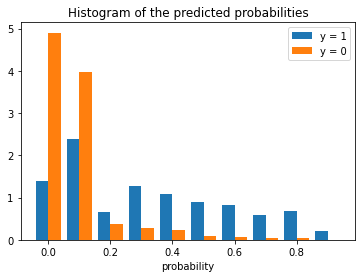

In [5]:
# Derive the probability predicted by the model for a set of validation data
X_train2, X_val, y_train2, y_val = train_test_split(X_train_comb,y_train,test_size=0.2,random_state=42,stratify=y_train)
gbc.fit(X_train2,y_train2)
y_proba = gbc.predict_proba(X_val)[:,1]

# Plot a histogram of the predicted probability for the validation data (distinguish between y = 0 and y = 1)
fig, ax = plt.subplots()
plt.hist([y_proba[y_val==1],y_proba[y_val==0]],density=True,bins=np.arange(-0.05,1.05,0.1))
ax.set_xlabel('probability')
ax.set_ylabel('')
ax.legend(['y = 1', 'y = 0'])
ax.set_title('Histogram of the predicted probabilities');

## Confusion matrix
Using the threshold of 0.2 for the probability, I now generate the confusion matrix (see below). As expected from the histogram of the probabilities shown above, the Gradient Boosting classifier performs well in classifying the instances with y = 0.  Only 10 % of the instances with y = 0 are classified as false positives. However, a large fraction (40 %) of the instances with y = 1 are classified as false negatives. Therefore, there are more false positives than true positives. Without using the predictions made by the model, 11 % of the clients, that are contacted, will subscribe to a term deposit. When taking into account the predictions made by the model (with a threshold of 0.2 for the probability), the success rate rises to 45 %. However, 40 % of the clients, who are potentially interested in a term deposit, will not be contacted. When increasing the threshold of the probability to 0.5, the success rate is even higher (64 %), but 70 % of the people interested in a loan will not be contacted. 

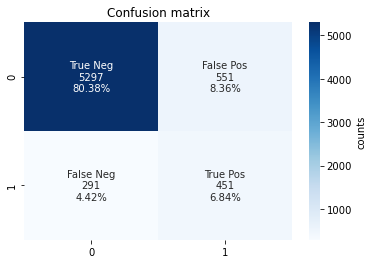

In [6]:
plot_confusion_matrix(y_val,y_proba,0.2)

## Feature importance
The Gradient Boosting classifier in scikit-learn also provides the importance of the individual features for the predictions. As can be seen in the plot below, the most important feature is poutcome_success which is a categorical variable describing whether a client subscribed to a term deposit in a previous telemarketing campaign. Clients are likely to subscribe to a term deposit if they have already done that in the past. The features describing the state of the economy are important, as well. If the economy is in a bad state, people are more interested in conservative options for investing money, such as term deposits.

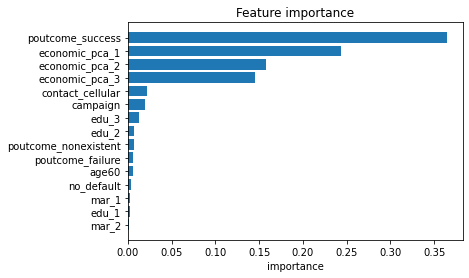

In [7]:
# Feature importance
fig, ax = plt.subplots()
sorted_idx = gbc.feature_importances_.argsort()
plt.barh(X_train_comb.columns[sorted_idx],gbc.feature_importances_[sorted_idx])
ax.set_xlabel('importance')
ax.set_title('Feature importance');

## Test data
In the last step, I apply the model on the test data. The ROC AUC score (0.82) is comparable to the one achieved on the train and on the validation data. Hence, the model does not overfit the data.

In [8]:
#ROC AUC for the test data
test_score = roc_auc_score(y_test,gbc.predict_proba(X_test_comb)[:,1])

display('Test data: ROC AUC =  {:.2f}'.format(test_score))

'Test data: ROC AUC =  0.82'

## Summary
The model uses a Gradient Boosting classifier to predict whether a client will subscribe to a term deposit. It achieves an ROC AUC score of 0.8. The main drawback of the model is the large amount of false negatives. The available features do not allow a clear identification of some of the clients who are interested in a term deposit. Nonetheless, the model is useful if there is only a limited capacity for telemarketing available. The threshold of the probability for a positive outcome can be adjusted according to the number of phone calls that can be made. In this way, only the clients that are the most likely to subscribe in a term deposit can be selected. For example, if the telemarketing campaign can only reach 10 % of the clients of the bank, selecting the clients based on the predictions of the Gradient Boosting classifier, 52 % of the contacted clients are expected to subscribe to a term deposit. Without using the model, only 11 % of the clients, that are contacted, would be interested in a term deposit.
Reducing the number of false negatives requires additional features. These could be, for example, the account balance of the customer or recent transactions.